# 1. Data Reading using pandas

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw.csv')

df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53040,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53041,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53042,53040,Is there any way to sleep better? I can't slee...,Anxiety
53043,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


# 2. Move each Correspondent status to each own list

depression list will only contains depression sentences and so are the rest.

In [2]:
depression = list()
personality_disorder = list()
bipolar = list()
anxiety = list()
stress = list()
normal = list()
suicide = list()

for i in range(len(df.status)):
    if df.status[i] == "Depression":
        depression.append(df.statement[i])
    elif df.status[i] == "Personality disorder":
        personality_disorder.append(df.statement[i])
    elif df.status[i] == "Bipolar":
        bipolar.append(df.statement[i])
    elif df.status[i] == "Anxiety":
        anxiety.append(df.statement[i])
    elif df.status[i] == "Stress":
        stress.append(df.statement[i])
    elif df.status[i] == "Normal":
        normal.append(df.statement[i])
    elif df.status[i] == "Suicidal":
        suicide.append(df.statement[i])
    else:
        continue

# 3. Labeled each sentences
"I'm so depressed" into ("I'm so depressed", "Depression")

In [3]:
labeled_sentences = list()

for sentence in depression:
    labeled_sentences.append((sentence, "Depression"))

for sentence in personality_disorder:
    labeled_sentences.append((sentence, "Personality Disorder"))

for sentence in bipolar:
    labeled_sentences.append((sentence, "Bipolar"))

for sentence in anxiety:
    labeled_sentences.append((sentence, "Anxiety"))

for sentence in stress:
    labeled_sentences.append((sentence, "Stress"))

for sentence in normal:
    labeled_sentences.append((sentence, "Normal"))

for sentence in suicide:
    labeled_sentences.append((sentence, "Suicidal"))

# 4. Seperates sentences and it's label into two different list

In [4]:
sentences = [str(sentence) for sentence, label in labeled_sentences]
labels = [str(label) for sentence, label in labeled_sentences]

Preprocess each sentences

In [5]:
import spacy
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

def understand_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [6]:
import re
from string import punctuation

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[\]]*', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [7]:
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')

def remove_stopwords(text: str) -> str:
    return ' '.join([word for word in text.split() if word not in eng_stopwords])

In [8]:
sentences = [preprocess_text(sentence) for sentence in sentences]
sentences = [remove_stopwords(sentence) for sentence in sentences]
sentences = [sentence for sentence in sentences if sentence != 'NaN']
sentences = [understand_text(sentence) for sentence in sentences]

# 5. Use TF-IDF to convert each sentences into a Vector Representative of words based on it's context.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             max_features=5000, 
                             stop_words='english', 
                             lowercase=True)
tfidf_vector = vectorizer.fit_transform(sentences)

tfidf_vector

<53042x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1704527 stored elements in Compressed Sparse Row format>

# 6. Encode the label into a matrix "Depression" into 2, "Suicidal" into 6 and etc.

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
label_arrays = encoder.fit_transform(labels)

label_arrays

array([2, 2, 2, ..., 6, 6, 6], dtype=int64)

# 7. Data training with (80:10:10) format

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tfidf_vector, label_arrays, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# 8. Create the neural network

In [38]:
import tensorflow as tf

model = tf.keras.Sequential([

    # Embedding layer for input sequences
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=5000),

    tf.keras.layers.Conv1D(64, 5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv1D(128, 5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv1D(256, 5, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.3),

    # Output layer for multi-class classification
    tf.keras.layers.Dense(len(set(label_arrays)), activation='softmax'),
])


In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(  monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.5, 
                                                    patience=1,
                                                    min_lr=1e-6)

In [41]:
history = model.fit(x_train,
                    y_train, 
                    epochs=40, 
                    batch_size=64, 
                    validation_data=(x_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/40
664/664 ━━━━━━━━━━━━━━━━━━━━ 765s 1s/step - accuracy: 0.3035 - loss: 1.6842 - val_accuracy: 0.3197 - val_loss: 1.5781 - learning_rate: 5.0000e-04
Epoch 2/40
664/664 ━━━━━━━━━━━━━━━━━━━━ 753s 1s/step - accuracy: 0.3297 - loss: 1.5816 - val_accuracy: 0.3316 - val_loss: 1.5649 - learning_rate: 5.0000e-04
Epoch 3/40
664/664 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.3308 - loss: 1.5771 - val_accuracy: 0.3318 - val_loss: 1.5646 - learning_rate: 5.0000e-04
Epoch 4/40
664/664 ━━━━━━━━━━━━━━━━━━━━ 839s 1s/step - accuracy: 0.3411 - loss: 1.5753 - val_accuracy: 0.3318 - val_loss: 1.5641 - learning_rate: 5.0000e-04
Epoch 5/40
664/664 ━━━━━━━━━━━━━━━━━━━━ 884s 1s/step - accuracy: 0.3388 - loss: 1.5681 - val_accuracy: 0.3318 - val_loss: 1.5648 - learning_rate: 5.0000e-04
Epoch 6/40
  8/664 ━━━━━━━━━━━━━━━━━━━━ 13:44 1s/step - accuracy: 0.3250 - loss: 1.5530

KeyboardInterrupt: 

In [25]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy with Neural Network: {accuracy}")

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5315 - loss: 1.2385
Test Accuracy with Neural Network: 0.5226244330406189


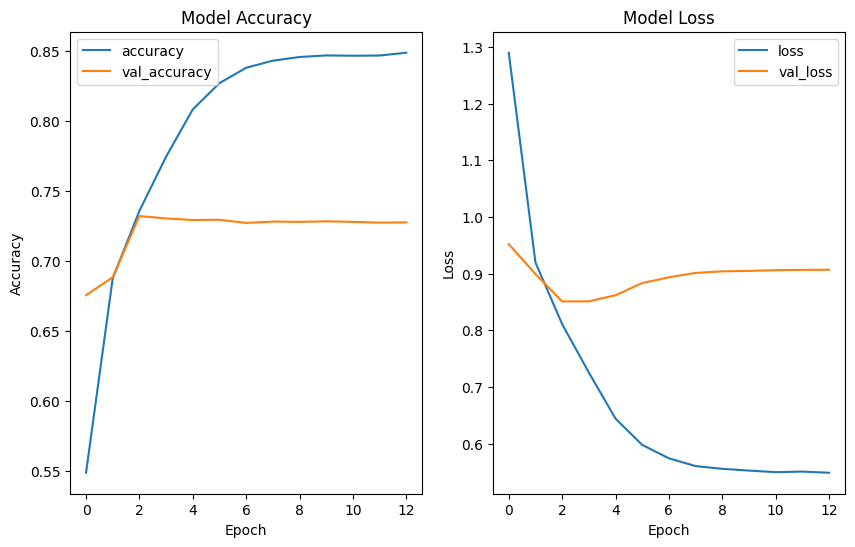

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [18]:
test = input()
test_vector = vectorizer.transform([test]).toarray()

prediction = model.predict(test_vector)
prediction = encoder.inverse_transform([prediction.argmax()])

print(f"Prediction: {prediction[0]}\n\n")
print("Percentages:")

labels = ["Anxiety", "Bipolar", "Depression", "Normal", "Personality Disorder", "Stress", "Suicidal"]
for i, label in enumerate(labels):
    percentage = model.predict(test_vector)[0][i] * 100  # Convert to percentage
    print(f"{label}: {percentage:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: Stress


Percentages:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Anxiety: 9.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bipolar: 6.77%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Depression: 4.58%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Normal: 29.13%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Personality Disorder: 7.26%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Stress: 35.74%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Suicidal: 7.39%


In [19]:
model.save('../models/model.keras')